In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import matplotlib.pyplot as plt
import numpy as np

## Model definition and parameters

##### Dynamic problem

The problem of an agent $i$ of age $t$ in the base model is recursively represented as

\begin{split}
V_{i,t} =& \max_{0\leq C_{i,t} \leq X_{i,t}, \alpha_{i,t}\in[0,1]} U(C_{i,t}) + \delta p_t E_t\{ V_{i,t+1} (X_{i,t+1}) \}\\
&\text{s.t}\\
&X_{i,t+1} = Y_{i,t+1} + (X_{i,t} - C_{i,t})(\alpha_{i,t} R_{t+1} + (1-\alpha_{i,t})\bar{R}_f)
\end{split}

where $C_{i,t}$ is consumption, $\alpha_{i,t}$ is the share of savings allocated to the risky asset, $Y_{i,t}$ is labor income, and $X_{i,t}$ represents wealth. The utility function $U(\cdot)$ is assumed to be CRRA in the base model. Extensions beyond the baseline model include an additively separable bequest motive in the utility function. The discount factor is $\delta$ and $p_t$ is the probability of survival from $t$ to $t+1$. Death is certain at a maximum period $T$.

Note that the consumer cannot borrow or short-sell.

The control variables in the problem are $\{C_{it}, \alpha_{it}\}^T_{t=1}$ and the state variables are $\{t, X_{it}, v_{it} \}^T_{t=1}$. The agent solves for  policy rules as a function of the state variables&mdash;$C_{it}(X_{it}, v_{it})$ and $\alpha_{it}(X_{it}, v_{it})$.



In [2]:
{
 'aNrmInitMean': 0.0, # Initial market resources, X above
 'aNrmInitStd': 1.0,
 'pLvlInitMean': 0.0, # Initial permanent income, Y above
 'pLvlInitStd': 0.0,
}

{'aNrmInitMean': 0.0,
 'aNrmInitStd': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0}

#### Labor income

An important driver of the paper's results is the labor income process. It is specified as follows:

\begin{equation}
\log Y_{i,t} = f(t,Z_{i,t}) + v_{i,t} + \epsilon_{i,t}, \quad \text{for } t\leq K.
\end{equation}

where $K$ is the (exogenous) age of retirement, $Z_{i,t}$ are demographic characteristics, $\epsilon_{i,t}\sim \mathcal{N}(0,\sigma^2_\epsilon)$ is a transitory shock, and  $v_{i,t}$ is a permanent component following a random walk

\begin{equation}
v_{i,t} = v_{i,t-1} + u_{i,t} = v_{i,t-1} + \xi_t + \omega_{i,t}
\end{equation}

in which the innovation is decomposed into an aggregate ($\xi_t$) and an idiosyncratic component ($\omega_{i,t}$), both following mean-0 normal distributions.

Post-retirement income is a constant fraction $\lambda$ of permanent income in the last working year $K$.

A crucial aspect of the labor income process is that $f(\cdot,\cdot)$ is calibrated to match income profiles in the PSID, capturing the usual humped shape of income across lifetime.



#### Matching labor income in HARK

In HARK's consumption-saving models, the income process takes the form
\begin{equation}
    \ln Y_t = \ln P_t + \ln \theta_t
\end{equation}
where $P_t$ represents permanent income and $\ln \theta_t \sim N(0,\sigma_\theta)$ transitory shocks to income. Permanent income evolves according to
\begin{equation}
    \ln P_{t+1} = \ln \Gamma_{t+1} +  \ln \psi_{t+1} + \ln P_t
\end{equation}
where $\Gamma_{t+1}$ is a deterministic growth factor, and $\ln \psi_{t+1} \sim N(0,\sigma_\psi)$ a permanent income shock. 


To represent the author's assumptions in HARK, we express both income processes as sums of deterministic components and i.i.d shocks
\begin{align}
\text{Cocco et. al} &\quad& \ln Y_{i,t} &=& f(t,Z_{i,t}) + v_{i,0} &+&\sum_{k=1}^t u_{i,k} &+&\qquad \varepsilon_{i,t} \\
\text{HARK}        &\quad& \ln Y_{i,t} &=& \ln P_{i,0} + \sum_{k=1}^t \ln \Gamma_k &+&\sum_{k=1}^t \ln \psi_{i,k} &+& \qquad \ln \theta_{i,t}.
\end{align}

These representations make evident the mapping that we use

|HARK | Cocco et. al |
| :---: | :-----------: |
| $\ln$ $P_{i,0}$ | $f(0,Z_{i,0})$ + $v_{i,0}$ |
| $\ln$ $\Gamma_{t+1}$| $f(t+1$, $Z_{i,t+1})$ - $f(t,Z_{i,t})$|
|$\ln$ $\psi_{i,k}$| $u_{i,k}$|
|$\ln$ $\theta_{i,t}$| $\varepsilon_{i,t}$|

and to achieve a retirement income that is equal to a fraction $\lambda$ of permanent income in the last working period $K$, we simply make $\Gamma_{K+1} = \lambda$ and $\Gamma_{t} = 1$ $\forall t>K+1$.



#### Assets and their returns

There are two assets available for consumers to allocate their savings.

- Bonds: paying a risk-free return $\bar{R}_f$.

- Stocks: paying a stochastic return $R_t = \bar{R}_f + \mu + \eta_t$, where the stochastic component $\eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$ is allowed to be correlated with the aggregate labor income innovation $\xi_t$.

The borrowing and short-selling constraints ensure that agents cannot allocate negative dollars to either of these assets or borrow against future labor income or retirement wealth. Recall $\alpha_{i,t}$ is the proportion of the investor's savings that are invested in the risky asset. The model's constraints imply that $\alpha_{i,t}\in[0,1]$ and wealth is non-negative.

In [3]:
{
 'Rfree': 1.03,
 'RiskyAvg': 1.08,
 'RiskyStd': 0.2,
 'RiskyCount': 5,
 'ShareCount': 25, ## This is a discretization parameter for approximation
 'AdjustPrb': 1.0,
 'DiscreteShareBool': False}

{'Rfree': 1.03,
 'RiskyAvg': 1.08,
 'RiskyStd': 0.2,
 'RiskyCount': 5,
 'ShareCount': 25,
 'AdjustPrb': 1.0,
 'DiscreteShareBool': False}

### Calibration&mdash;Summary

The paper defines and calibrates several parameters which can be broken down into the following categories:

__1. Preferences and life cycle__

 | Parameter | Description | Code | Value |
 |:---:| ---         | ---  | :---: |
 | $\delta$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
 | $\gamma$ | Coefficient of Relative Risk Aversion| $\texttt{CRRA}$ | 10 |
 | $p_t$ | Survival Probability | $\texttt{LivPrb}$ | [0.6809,0.99845] |
 | $t_0$ | Starting Age | $\texttt{t_start}$ | 20 |
 | $t_r$ | Retirement Age | $\texttt{t_ret}$ | 65 |
 | $T$ | Maximum Age | $\texttt{t_end}$ | 100 |



In [4]:
lc = {
 'CRRA': 5.0,
 'DiscFac': 0.9,
 'LivPrb': [0.98],
 'T_age': None,
 'T_cycle': 1,
 'T_retire': 0,
}

__2. Income process and the finanical assets__

 | Parameter | Description | Code | Value|
 |:---:| ---         | ---  | :---: |
 | $f(t,Z_{i,t})$| Average income at each stage of life | $\texttt{det_income}$ | $ \exp($0.530339 + 0.16818 $t$+ (0.0323371/10) $t^2$ + (0.0019704/100) $t^3)$ |
 | $\lambda$ | Last Period Labor Income Share for Retirement | $\texttt{repl_fac}$ | 0.68212 |
 | $\log \Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | $\{\log f_{t+1} - \log f_t\}^{t_r+1}_{t=20}$ |
 | $\mathsf{R}$ | Interest Factor | $\texttt{Rfree}$ | 1.02 |
 | $\mu$ | Average Stock Return | $\texttt{RiskyDstnFunc}$ \& $\texttt{RiskyDrawFunc}$ | 1.06 |
 | $\sigma_\eta$ | Std Dev of Stock Returns | $\texttt{RiskyDstnFunc}$ \& $\texttt{RiskyDrawFunc}$ | 0.157 |




__3. Shocks__

 | Parameter | Description | Code | Value |
 |:---:| ---         | ---  | :---: |
 | $\sigma_v$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.102956 |
 | $\sigma_\epsilon$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.27166 |

In [5]:
{
 'PermShkStd': [0.1],
 'PermShkCount': 7,
 'TranShkStd': [0.1],
 'TranShkCount': 7,
 }

{'PermShkStd': [0.1],
 'PermShkCount': 7,
 'TranShkStd': [0.1],
 'TranShkCount': 7}

In [6]:
cpm.init_portfolio

{'CRRA': 5.0,
 'Rfree': 1.03,
 'DiscFac': 0.9,
 'LivPrb': [0.98],
 'PermGroFac': [1.01],
 'BoroCnstArt': 0.0,
 'MaxKinks': 400,
 'AgentCount': 10000,
 'aNrmInitMean': 0.0,
 'aNrmInitStd': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'PermGroFacAgg': 1.0,
 'T_age': None,
 'T_cycle': 1,
 'aXtraMin': 0.001,
 'aXtraMax': 100,
 'aXtraNestFac': 1,
 'aXtraCount': 200,
 'aXtraExtra': [None],
 'PermShkStd': [0.1],
 'PermShkCount': 7,
 'TranShkStd': [0.1],
 'TranShkCount': 7,
 'UnempPrb': 0.05,
 'UnempPrbRet': 0.005,
 'IncUnemp': 0.3,
 'IncUnempRet': 0.0,
 'tax_rate': 0.0,
 'T_retire': 0,
 'vFuncBool': False,
 'CubicBool': False,
 'RiskyAvg': 1.08,
 'RiskyStd': 0.2,
 'RiskyCount': 5,
 'ShareCount': 25,
 'AdjustPrb': 1.0,
 'DiscreteShareBool': False}

This is what it looks like when it's put all together.

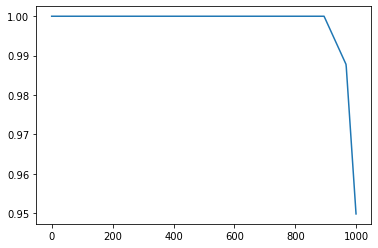

In [7]:
agent = cpm.PortfolioConsumerType()
agent.solve()
plt.plot(agent.solution[0].ShareFuncAdj(np.linspace(0,1,1000)))

In [8]:
dir(agent.solution[0])

['ShareFuncAdj',
 'ShareFuncFxd',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'assignParameters',
 'cFuncAdj',
 'cFuncFxd',
 'distance',
 'distance_criteria',
 'dvdmFuncFxd',
 'dvdsFuncFxd',
 'getAvg',
 'vFuncAdj',
 'vFuncFxd',
 'vPfuncAdj']

## Integrating with the Liquidity Model

To integrate with the LiquidityModel in NetLogo, we need code that:

- Collects price data from the LiquidityModel
- Inputs this data to the consumer agents, which then compute their demand for the risky asset
- Aggregates the consumer demand.



### Demand function for the intermittent demand problem

In the intermittent demand problem, consumers take their current state and determine risky porfolio share of their assets to invest.

Their current state includes:
 * currently available market resources
 * beliefs about the risky rate of return and volatility

Other aspects of the problem are fixed for now.

In [9]:
def demand(
    market_resources,
    permanent_income,
    risky_avg_belief,
    risky_std_belief,
    agent_parameters = {}
):
    '''
    Returns:
      - the risky share
      - the dollar value of risky assets
      - the dollar value of non-risky market assets
    '''
    
    params = {
        'RiskyAvg': risky_avg_belief,
        'RiskyStd': risky_std_belief,
    }
    
    ap = agent_parameters.copy()
    
    ap.update(params)
    
    agent = cpm.PortfolioConsumerType(**ap)
    agent.solve()
    
    # ShareFunc takes normalized market resources as argument
    risky_share = agent.solution[0].ShareFuncAdj(market_resources / permanent_income).tolist()
    return risky_share, market_resources * risky_share, market_resources * (1 - risky_share)

In [10]:
demand(1000,50,1.1,0.5)

(0.08258400943880966, 82.58400943880966, 917.4159905611904)

### Synthetic price data

In the future, get this from the LiquidityModel.

For now, just use any array of prices with noise and drift.

In [11]:
return_rate = .05
time_steps = 1000

def random_prices(return_rate = return_rate, time_steps = time_steps):
    prices = np.random.random(
        time_steps) + np.arange(0,
                                return_rate,return_rate / time_steps)
    
    return prices

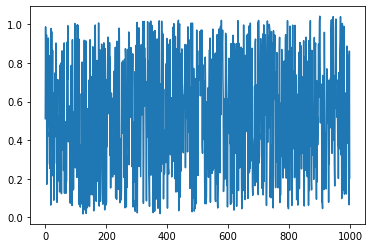

In [12]:
prices = random_prices()

plt.plot(prices)

### Agents estimate return rate and volatility from historical data

The agents look at the most recent historical price data to form their expectations of the future.

This is a very simplified version of what could later be better specified in line with _adaptive expectations_:

https://en.wikipedia.org/wiki/Adaptive_expectations

In [13]:
from statistics import mean

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b



In [14]:
def estimated_rate_of_return(prices):
    m, b = best_fit_slope_and_intercept(np.arange(prices.size), prices)
    
    return 1 + m * prices.size


In [15]:
estimated_rate_of_return(prices)

1.0563314328150595

In [16]:
np.std(prices)

0.2935649818484845

### Computation of today's market assets

***TODO***: How do we simulate the market assets of the agent, when we are externalizing the part of the simulation that handles the risk asset?

**What's below is a hack.**

In [17]:
def new_market_assets(
    old_risky_allocation,
    old_risk_free_allocation,
    prices,
    risk_free_rate
):

    return old_risky_allocation * prices[-1] / prices[0] \
            + old_risk_free_allocation * risk_free_rate

### Putting it all together

Each agent knows their old risky allocation, old risk free allocation, and the prices of the last quarter.

They computer their new market assets and then their new demand.

In [18]:
def update_demand(
    permanent_income, ## TODO : where is this getting pulled from? 
    old_risky_allocation,
    old_risk_free_allocation,
    prices,
    risk_free_rate,
    agent_parameters = {}
):
    market_resources = new_market_assets(
        old_risky_allocation,
        old_risk_free_allocation,
        prices,
        risk_free_rate
    )
    
    risky_avg_belief = estimated_rate_of_return(prices)
    risky_std_belief = np.std(prices)
    
    s, r, rf = demand(
        market_resources,
        permanent_income,
        risky_avg_belief,
        risky_std_belief,
        agent_parameters = agent_parameters
    )
    
    return s, r, rf
    

In [19]:
prices = random_prices()

s, r, rf  = update_demand(1, 800, 9200, prices, 1.01)
print(s, r, rf)

0.022982869313107106 234.17948703060534 9955.126462555638


In [20]:
prices = random_prices()


s, r, rf  = update_demand(1, r, rf, prices, 1.01)
print(s, r, rf)

0.0 0.0 10348.655456771925


### Aggregating and distributing across many agents

This works for multiple agents with different parameters.

In [21]:
## List of tuples: (parameters, number of agents represented)
agents = [
    ({'CRRA': 5.0}, 100), # Normal consumers
    ({'CRRA': 6.0}, 50), # More risk-averse consumers
    ({'CRRA': 4.0}, 50)  # Less risk-averse consumers
    
]

## initialize
shares = [
    (0.08, 800, 9200),
    (0.08, 800, 9200),
    (0.08, 800, 9200)
]

print(sum([s[1] for s in shares]))

prices = random_prices()

print(prices[-1] / prices[0])

shares = [
    update_demand(1,
                  shares[i][1],
                  shares[i][2],
                  prices,
                  1.01,
                  agent_parameters = agent_count[0]) 
 for i, agent_count in enumerate(agents)]

sum([s[1] for s in shares])

2400
26.472811246827344


3118.3882913835664

In [22]:
prices = random_prices()

print(prices[-1] / prices[0])

shares = [
    update_demand(1,
                  shares[i][1],
                  shares[i][2],
                  prices,
                  1.01,
                  agent_parameters = agent_count[0]) 
 for i, agent_count in enumerate(agents)]

sum([s[1] for s in shares])

0.1916448390218377


871.431868209487